In [9]:
import numpy as np
import sys, os
import _pickle as pickle

import plotly.graph_objects as go
import plotly.express as ex
from plotly.subplots import make_subplots
from cytoolz.itertoolz import concat, sliding_window
import scipy.signal as signal

sys.path.append("../")
import func

# Test local motion phases

In [5]:
# Load data
data_path = "../../data/"
data1 = func.load(data_path+"LOCO_R2-default-locomotion.pbz2")
data2 = func.load(data_path+"LOCO_R2-default-locomotion-large.pbz2")
d1 = pickle.loads(data1[10])  # only inspect the first animation sequence
d2 = pickle.loads(data2[10])  # only inspect the first animation sequence

In [7]:
# check pos, rot, velocity
def loadFeatures(data, feature_list):
    features = []
    for f in data["frames"]:
        p = []
        for feature in feature_list:
            if feature == "rotMat":
                p.append(np.concatenate([jo["rotMat"].ravel() for jo in f]))
            else:
                p.append(np.concatenate([jo[feature] for jo in f]))

        p = np.concatenate(p)
        features.append(p)
    return np.vstack(features)

In [12]:
rig1_p = loadFeatures(d1, ["pos"])
rig2_p = loadFeatures(d2, ["pos"])


In [38]:
# plot position for R2 default
def draw_pos(pos, name, width=800, height=600, reshape=(21,120,3)):
    fig = make_subplots(rows=3, cols=1, subplot_titles=["X", "Y", "Z"])
    shape = pos.shape
    pos = np.reshape(pos, reshape)
    x = np.arange(shape[0])
    i = 0
    for j in pos:
        y = [t[0] for t in j]
        y1 = [t[1] for t in j]
        y2 = [t[2] for t in j]
        fig.add_trace(go.Scatter(x=x, y=y, name="J{}".format(i), mode="lines"), row=1, col=1)
        fig.add_trace(go.Scatter(x=x, y=y1, name="J{}".format(i), mode="lines"), row=2, col=1)
        fig.add_trace(go.Scatter(x=x, y=y2, name="J{}".format(i), mode="lines"), row=3, col=1)
        i+=1

    fig.update_layout(title=name, height=height, width=width)
    fig.update_xaxes(title_text="Frame")
    fig.update_yaxes(title_text="position")
    fig.show()


In [39]:
draw_pos(rig1_p, "R2 Default")

In [40]:
draw_pos(rig2_p, "R2 Large")


In [ ]:
rig1_p.shape

In [ ]:
# Extract the contact info per joint per frame
contact_info = []
for f in d1["frames"]:
    contacts = np.asarray([jo["contact"] for jo in f]).astype(np.int)
    contact_info.append(contacts)
contact_info = np.vstack(contact_info)
print(contact_info.shape)

In [67]:
# plot the contact info
cInfo = contact_info.T
x = np.arange(contact_info.shape[0])

fig = go.Figure()
i = 0
for jo in cInfo:
    fig.add_trace(go.Scatter(x=x, y=jo, name="J"+str(i)))
    i+=1
fig.show()

In [186]:
def normalise(block_fn:np.ndarray, n_windows:int=10) -> np.ndarray:
    """
    Takes an ndarray of shape(n_joints, n_frames), where 1 = contact and 0 otherwise.
    :param block_fn:
    :param n_windows:
    :return:
    """
    window_size = block_fn.shape[1] / n_windows
    idx = (np.arange(n_windows) * window_size).astype(np.int)
    for i, ii in zip(idx[:-1], idx[1:]):
        slice = block_fn[:, i:ii]
        mean = np.mean(slice, axis=1, keepdims=True)
        std = np.std(slice, axis=1, keepdims=True)
        std[std == 0] = 1

        block_fn[:, i:ii] = (slice-mean) / std

    f_sample = block_fn.shape[1] / 60


    filter = signal.butter(3, 1/3.25, "low", analog=False, output="sos")
    block_fn = signal.sosfilt(filter, block_fn)
    return block_fn

def calc_local_motion_phase(block_fn:np.ndarray) -> np.ndarray:
    """
    Takes the contact info and approximates the local motion phase, as described in [Local Motion Phases for Learning Multi-Contact Character Movements]
    :param block_fn:
    :return:
    """
    block_fn = normalise(block_fn)
    # WIP....
    return block_fn



In [185]:
# plot the normalised contact info
cInfo = calc_local_motion_phase(np.copy(contact_info.T))
x = np.arange(contact_info.shape[0])

fig = go.Figure()
i = 0
for jo in cInfo:
    fig.add_trace(go.Scatter(x=x, y=jo, name="J"+str(i)))
    i+=1
fig.show()


In [204]:
# test evostrat....
# didnt work....
from evostra import EvolutionStrategy

Frames = 120
a = np.ones(Frames)
f = np.ones(Frames)
s = np.zeros(Frames)
b = np.zeros(Frames)
params = np.column_stack([a,f,s,b])
t = np.arange(Frames)

def infer(t, params):
    return params[0] * np.sin(params[1] * t - params[2]) + params[3]

def loss(params, row_fn, N=60):
    return np.sqrt(
        (infer(t, params) - row_fn)**2 / N
    )

def get_reward(params):
    global container
    container[0] = params
    return -loss(container[0], row_fn)

container = [params]
row_fn = cInfo[14]
es = EvolutionStrategy(container[0], get_reward, population_size=10, sigma=0.1, learning_rate=0.03, decay=0.995, num_threads=1)
es.run(100, print_step=20)

ValueError: operands could not be broadcast together with shapes (4,) (120,) 

In [210]:
from scipy.optimize import minimize

# test L-BFGS-B...
# and it works...maybe....

def func(x, *args):
    t = args[0]
    y = args[1]

    return np.sqrt(
        (infer(t, x) - y)**2 / 60
    )

results = []
for ts in t:
    res = minimize(func, params[ts], args=(ts, row_fn[ts]), method="L-BFGS-B")
    results.append(res)

In [215]:
# plot the approximated motion phases
amp = np.asarray([res.x[0] for res in results], dtype=np.float32)
freq = np.asarray([res.x[0] for res in results], dtype=np.float32)
phase = np.asarray([res.x[0] for res in results], dtype=np.float32)
bias = np.asarray([res.x[0] for res in results], dtype=np.float32)

x = np.arange(contact_info.shape[0])
y = infer(t, [amp, freq, phase, bias])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))
fig.show()


# Testing on another motion data


In [237]:
# testing one anohter motion data
data_path = "../../data/"
data = f.load(data_path+"ONE_R1-default-One.pbz2")
d1 = pickle.loads(data[0])

contact_info = []
for f in d1["frames"]:
    contacts = np.asarray([jo["contact"] for jo in f]).astype(np.int)
    contact_info.append(contacts)
contact_info = np.vstack(contact_info)
print(contact_info.shape)

cInfo = contact_info.T
x = np.arange(contact_info.shape[0])

fig = go.Figure()
i = 0
for jo in cInfo:
    fig.add_trace(go.Scatter(x=x, y=jo, name="J"+str(i)))
    i+=1
fig.show()


cInfo = calc_local_motion_phase(np.copy(contact_info.T))


x = np.arange(contact_info.shape[0])

fig = go.Figure()
i = 0
for jo in cInfo:
    fig.add_trace(go.Scatter(x=x, y=jo, name="J"+str(i)))
    i+=1
fig.show()



Frames = 120
a = np.ones(Frames)
f = np.ones(Frames)
s = np.ones(Frames)
b = np.ones(Frames)
params = np.column_stack([a,f,s,b])
t = np.arange(Frames)
row_fn = cInfo[6]

def infer(t, params):
    return params[0] * np.sin(params[1] * t - params[2]) + params[3]

from scipy.optimize import minimize

def func(x, *args):
    t = args[0]
    y = args[1]

    return np.sqrt(
        (infer(t, x) - y)**2 / 60
    )

results = []
for ts in t:
    res = minimize(func, params[ts], args=(ts, row_fn[ts]), method="L-BFGS-B")
    results.append(res)

amp = np.asarray([res.x[0] for res in results], dtype=np.float32)
freq = np.asarray([res.x[0] for res in results], dtype=np.float32)
phase = np.asarray([res.x[0] for res in results], dtype=np.float32)
bias = np.asarray([res.x[0] for res in results], dtype=np.float32)

x = np.arange(contact_info.shape[0])
y = infer(t, [amp, freq, phase, bias])

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))
fig.show()

AttributeError: 'numpy.ndarray' object has no attribute 'load'

# Test NPSS


In [137]:
data_path = "../../data/"
data = func.load(data_path+"ONE_R1-default-One.pbz2")
data2 = func.load(data_path+"ONE_R1-default-One.pbz2")
d1 = pickle.loads(data[0])
d2 = pickle.loads(data2[1])

In [138]:
inputs = []
inputs2 = []
for f in d1["frames"]:
    p = np.concatenate(
        [
            np.concatenate([jo["pos"] for jo in f]),
            np.concatenate([jo["rotMat"].ravel() for jo in f]),
            np.concatenate([jo["velocity"] for jo in f]),
         ])
    inputs.append(p)
inputs = np.vstack(inputs)

for f in d2["frames"]:
    p = np.concatenate(
        [
            np.concatenate([jo["pos"] for jo in f]),
            np.concatenate([jo["rotMat"].ravel() for jo in f]),
            np.concatenate([jo["velocity"] for jo in f]),
         ])
    inputs2.append(p)
inputs2 = np.vstack(inputs2)
print(inputs.shape)

(120, 315)


In [139]:
std = np.std(inputs, axis=0, keepdims=True)
std2 = np.std(inputs2, axis=0, keepdims=True)
std[std==0] = 1
std2[std2==0] = 1
inputs = (inputs - np.mean(inputs, axis=0, keepdims=True)) / std
inputs2 = (inputs2 - np.mean(inputs2, axis=0, keepdims=True)) / std2

In [140]:
ts = 1/60

transformed = np.abs(np.fft.fft(inputs, axis=0))**2
transformed2 = np.abs(np.fft.fft(inputs2, axis=0))**2

In [ ]:
freq = np.fft.fftfreq(inputs.shape[0], ts)

idx = np.argsort(freq)

fig = ex.scatter(x=freq[idx], y=transformed[idx,2])
fig.show()
# transformed2 = np.fft.fft(inputs2, axis=0)
# print(transformed.shape)

In [77]:
a = ex.scatter(x=np.arange(len(freq)), y=freq)
a.show()

In [78]:
print(idx)

[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59]


In [107]:
# ex.imshow(inputs, color_continuous_scale="RdBu_r")
ex.imshow(transformed, color_continuous_scale="RdBu_r")


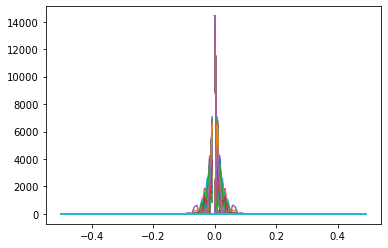

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(inputs2.shape[0])
freq = np.fft.fftfreq(inputs2.shape[0])
plt.plot(freq, transformed2.real, freq, transformed2.imag)
plt.show()


In [141]:
t = transformed
t2 = transformed2

tNorm = t / (np.sum(t, axis=0, keepdims=True)+1)
tNorm2 = t2 / (np.sum(t2, axis=0, keepdims=True)+1)

In [142]:
emd = np.linalg.norm(tNorm-tNorm2, ord=1)

In [143]:
pij = np.sum(t, axis=0, keepdims=True)
npss = np.sum(pij * emd) / np.sum(pij)

In [144]:
npss

1.7165651533422985

In [145]:
emd


1.7165651533422983

In [93]:
t

array([[14400., 14400., 14400., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [94]:
t2

array([[14400., 14400., 14400., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [100]:
ex.imshow(inputs)

In [101]:
ex.imshow(inputs2)

In [148]:

data_path = "../../data/"
data1 = func.load(data_path+"ONE_R2-default-One.pbz2")
data1_1 = func.load(data_path+"ONE_R2-default-One-small.pbz2")
data1_2 = func.load(data_path+"ONE_R2-default-One-large.pbz2")
data2_1 = func.load(data_path+"ONE_R1-default-One.pbz2")
data2_2 = func.load(data_path+"ONE_R1-default-One-large.pbz2")
data3 = func.load(data_path+"ONE_R5-default-One.pbz2")
data4 = func.load(data_path+"TWO_R2-default-Two.pbz2")
data4_1 = func.load(data_path+"TWO_ROT_R2-default-Two.pbz2")
data4_2 = func.load(data_path+"LOCO_R2-default-locomotion.pbz2")

In [152]:

def normalise(x):
    std = np.std(x, axis=0, keepdims=True)
    std[std==0] = 1
    return (x-np.mean(x)) / std

def comp(D):
    D1 = D[0]
    D2 = D[1]

    seq1 = []
    seq2 = []
    for d,d2 in zip(D1,D2):
        d = pickle.loads(d)
        d2 = pickle.loads(d2)

        frames, frames2 = [], []
        for f in d["frames"]:
            p = np.concatenate(
                [
                    np.concatenate([jo["pos"] for jo in f]),
                    np.concatenate([jo["rotMat"].ravel() for jo in f]),
                    np.concatenate([jo["velocity"] for jo in f]),
                 ])
            frames.append(p)
        for f in d2["frames"]:
            p = np.concatenate(
                [
                    np.concatenate([jo["pos"] for jo in f]),
                    np.concatenate([jo["rotMat"].ravel() for jo in f]),
                    np.concatenate([jo["velocity"] for jo in f]),
                 ])
            frames2.append(p)

        frames = normalise(frames)
        frames2 = normalise(frames2)

        seq1.append(np.vstack(frames))
        seq2.append(np.vstack(frames2))

    return seq1, seq2

def intra_diff(seq):
    c1 = seq[0]
    fft = np.abs(np.fft.fft(c1, axis=0))**2
    s1 = np.sum(fft, axis=0, keepdims=True)
    s1[s1==0] = 1
    fft_norm = fft / s1

    diffs = []
    for c in seq[1:]:
        fft2 = np.abs(np.fft.fft(c, axis=0))**2
        s2 = np.sum(fft2, axis=0, keepdims=True)
        s2[s2==0] = 1
        fft_norm2 = fft2/s2

        emd = np.linalg.norm(fft_norm-fft_norm2, ord=1)
        npss = np.sum(s1 * emd) / np.sum(s1)
        diffs.append(npss)
    return diffs
def inter_diff(seq, seq2):
    def calc(c):
        fft = np.abs(np.fft.fft(c, axis=0))**2
        s1 = np.sum(fft, axis=0, keepdims=True)
        s1[s1==0] = 1
        fft_norm = fft / s1
        return fft_norm, s1

    diffs = []
    for c1, c2 in zip(seq, seq2):
        fft_norm, s1 = calc(c1)
        fft_norm2, s2 = calc(c2)

        emd = np.linalg.norm(fft_norm-fft_norm2, ord=1)
        npss = np.sum(s1 * emd) / np.sum(s1)
        diffs.append(npss)
    return diffs

In [162]:
def plot_intra_diff(D):
    seq1, seq2 = comp(D)
    intra_diff1 = intra_diff(seq1)
    intra_diff2 = intra_diff(seq2)

    avg1 = np.mean(intra_diff1)
    avg2 = np.mean(intra_diff2)

    x = np.arange(len(intra_diff1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=intra_diff1, name="d1", mode="lines"))
    fig.add_trace(go.Scatter(x=x, y=intra_diff2, name="d2", mode="lines"))

    fig.add_trace(go.Scatter(x=[x[0], x[-1]], y=[avg1, avg1], name="d1 avg"))
    fig.add_trace(go.Scatter(x=[x[0], x[-1]], y=[avg2, avg2], name="d2 avg"))
    fig.update_layout(title_text="NPSS between clip 0 and clip i in the datasets D1 and D2 \n (the lower the more similar)")
    fig.show()

def plot_inter_diff(D):
    seq1, seq2 = comp(D)
    inter_diff1 = inter_diff(seq1, seq2)
    avg = np.mean(inter_diff1)

    x = np.arange(len(inter_diff1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=inter_diff1, name="d1", mode="lines"))

    fig.add_trace(go.Scatter(x=[x[0], x[-1]], y=[avg, avg], name="d1 avg"))

    fig.update_layout(title_text="NPSS between c1_i and c2_i in the datasets D1 and D2 \n (the lower the more similar)")
    fig.show()


In [171]:
data = [data1, data1_1, data1_2, data2_1, data2_2, data3, data4,data4_1, data4_2]
D = [data1, data1_1] # one-default, one-small

In [166]:
plot_intra_diff(D)

In [164]:
plot_inter_diff(D)

In [167]:
D = [data1, data1_2] # one-default, one-large
plot_intra_diff(D)

In [168]:
plot_inter_diff(D)

In [172]:
D = [data2_1, data2_2] # R1-one-default, R1-one-large
plot_intra_diff(D)

In [173]:
plot_inter_diff(D)


In [175]:
D = [data1, data2_1] # R2-one-default, R1-one-default
plot_inter_diff(D)

In [176]:
D = [data1, data3] # R2-one-default, R5-one-default
plot_intra_diff(D)

In [182]:
D = [data4, data4_1] # R2-two-default, R2-two_rot-default
plot_intra_diff(D)

In [183]:
plot_inter_diff(D)

In [184]:
D = [data4, data4_2] # R2-two-default, R2-loco-default
plot_intra_diff(D)

In [185]:
plot_inter_diff(D)

In [193]:
D = [data1, data4] # R2-one-default, R2-two-default
plot_inter_diff(D)

In [194]:
D = [data1, data4_1] # R2-one-default, R2-two_rot-default
plot_inter_diff(D)